In [1]:
import numpy as np
import time
import copy
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,SubsetRandomSampler
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix , precision_score, recall_score

In [12]:
data_dir = 'E:/train_data'

In [13]:
transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [14]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transforms[x])
                  for x in ['train', 'val', 'test']}

In [15]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 13619
     Root location: E:/train_data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 2719
     Root location: E:/train_data\val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 1825
     Root location: E:/train_data\test
     StandardTransform
 Transform: Compose(
            

In [16]:
class_names=image_datasets['train'].classes
class_names = [label.replace('_', '') for label in class_names]
class_names

['PotatoEarlyblight',
 'PotatoLateblight',
 'Potatohealthy',
 'TomatoBacterialspot',
 'TomatoEarlyblight',
 'TomatoLateblight',
 'TomatoLeafMold',
 'TomatoSeptorialeafspot',
 'TomatoSpidermitesTwospottedspidermite',
 'TomatoTargetSpot',
 'TomatoTomatoYellowLeafCurlVirus',
 'TomatoTomatomosaicvirus',
 'Tomatohealthy']

In [17]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}

In [18]:
data_size = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
data_size

{'train': 13619, 'val': 2719, 'test': 1825}

In [10]:
model = models.resnet34(pretrained=True)

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
model.fc = nn.Linear(model.fc.in_features,len(class_names))

In [15]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / data_size[phase]
            epoch_acc = running_corrects.double() / data_size[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
model=model.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
optimizer_conv = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_r = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.4127 Acc: 0.5297
val Loss: 0.4527 Acc: 0.8628

Epoch 1/19
----------
train Loss: 0.7503 Acc: 0.7553
val Loss: 0.3418 Acc: 0.8845

Epoch 2/19
----------
train Loss: 0.5602 Acc: 0.8155
val Loss: 0.2587 Acc: 0.9158

Epoch 3/19
----------
train Loss: 0.4617 Acc: 0.8501
val Loss: 0.1984 Acc: 0.9356

Epoch 4/19
----------
train Loss: 0.4225 Acc: 0.8637
val Loss: 0.1925 Acc: 0.9309

Epoch 5/19
----------
train Loss: 0.3734 Acc: 0.8751
val Loss: 0.1377 Acc: 0.9544

Epoch 6/19
----------
train Loss: 0.3339 Acc: 0.8897
val Loss: 0.1548 Acc: 0.9526

Epoch 7/19
----------
train Loss: 0.2142 Acc: 0.9269
val Loss: 0.0718 Acc: 0.9772

Epoch 8/19
----------
train Loss: 0.1838 Acc: 0.9385
val Loss: 0.0772 Acc: 0.9720

Epoch 9/19
----------
train Loss: 0.1639 Acc: 0.9447
val Loss: 0.0954 Acc: 0.9640

Epoch 10/19
----------
train Loss: 0.1579 Acc: 0.9490
val Loss: 0.0666 Acc: 0.9761

Epoch 11/19
----------
train Loss: 0.1530 Acc: 0.9493
val Loss: 0.0542 Acc: 0.9790

Ep

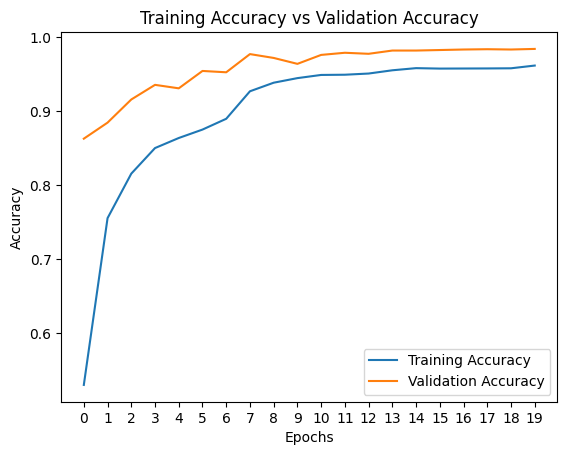

In [3]:
import matplotlib.pyplot as plt

# Example data
epochs = [i for i in range(20)]
train_acc = [0.5297, 0.7553, 0.8155, 0.8501, 0.8637, 0.8751, 0.8897, 0.9269, 0.9385, 0.9447, 0.9490, 0.9493, 0.9509, 0.9553, 0.9582, 0.9576, 0.9577, 0.9578, 0.9580, 0.9617]
val_acc = [0.8628, 0.8845, 0.9158, 0.9356, 0.9309, 0.9544, 0.9526, 0.9772, 0.9720, 0.9640, 0.9761, 0.9790, 0.9776, 0.9820, 0.9820, 0.9827, 0.9834, 0.9838, 0.9834, 0.9842]

# Plotting the data
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend()
plt.xticks(epochs)
# Display the plot
plt.show()

In [18]:
model_r.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
model_r=torch.load('resnet34.pth')

In [21]:
with torch.no_grad():
    
    accuracy = 0
    total_samples = 0
    correct_predictions = 0
    predicted_labels = []
    true_labels = []

    
    for images, labels in dataloaders['test']:
        images = images.to(device)
        labels = labels.to(device)

        
        outputs = model_r(images)

        
        _, predicted = torch.max(outputs.data, 1)

        
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

       
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

   
    accuracy =  correct_predictions / total_samples
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    
    f_score = f1_score(true_labels, predicted_labels, average='weighted')

    
    confusion_mat = confusion_matrix(true_labels, predicted_labels)

print("Accuracy: {:.5f}%".format(accuracy))

Accuracy: 0.98904%


In [22]:
print("Precision: {:.5f}".format(precision))

Precision: 0.98943


In [23]:
print("recall: {:.5f}".format(recall))

recall: 0.98904


In [24]:
print("F-score: {:.5f}".format(f_score))

F-score: 0.98904


In [25]:
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[100   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  95   3   0   0   2   0   0   0   0   0   0   0]
 [  0   0  16   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 213   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  98   1   0   0   1   0   0   0   0]
 [  1   0   0   0   0 190   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0  96   0   0   0   0   0   0]
 [  0   0   0   0   0   1   1 176   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 168   0   0   0   0]
 [  0   1   0   0   1   0   0   1   1 132   0   0   5]
 [  0   0   0   0   0   0   0   0   0   0 322   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  39   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 160]]


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

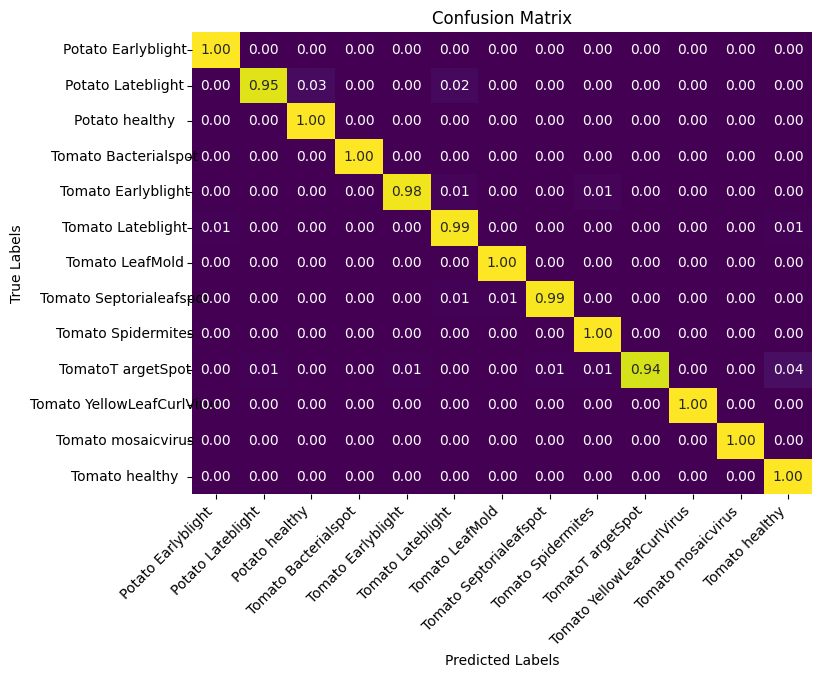

In [27]:
# Create a list of class labels
class_labels =  ['Potato Earlyblight','Potato Lateblight','Potato healthy','Tomato Bacterialspot','Tomato Earlyblight',
                 'Tomato Lateblight','Tomato LeafMold','Tomato Septorialeafspot','Tomato Spidermites','TomatoT argetSpot',
                 'Tomato YellowLeafCurlVirus','Tomato mosaicvirus','Tomato healthy']

# Normalize the confusion matrix
normalized_confusion_mat = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix as a heatmap
heatmap = sns.heatmap(normalized_confusion_mat, annot=True, fmt='.2f', cmap='viridis', cbar=False, ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

heatmap.set_xticklabels(class_labels, rotation=45, ha='right')
heatmap.set_yticklabels(class_labels, rotation=0, ha='center')

# Adjust the spacing between y-axis labels
ax.tick_params(axis='y', pad=45)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)



# Show the plot
plt.show()

In [30]:
torch.save(model_r,'resnet34.pth')

In [3]:
from torchsummary import summary

In [4]:
summary(model_r, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,